<a href="https://colab.research.google.com/github/M0hammad-Kashif/Notebooks/blob/main/Toxixcity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.8.0
Hub version:  0.12.0
GPU is available


In [2]:
df = pd.read_csv('/content/drive/Shareddrives/courseDrive/toxicity_dataset/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


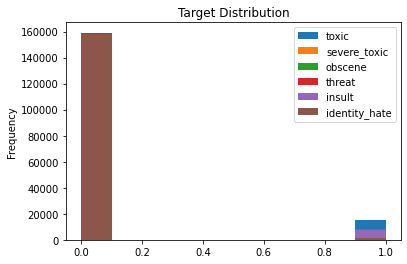

In [4]:
df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].plot(kind='hist',title='Target Distribution');

In [5]:
from sklearn.model_selection import train_test_split
train_df,remaining=train_test_split(df,random_state=42,train_size=0.01)
validation_df,_=train_test_split(remaining,random_state=42,train_size=0.004)
train_df.shape,validation_df.shape

((1595, 8), (631, 8))

In [6]:
train_df.drop('id',axis=1,inplace=True)


In [7]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
157087,"""\n\n Rayleigh scattering \n\nThere is a """"cit...",0,0,0,0,0,0
125150,"""\n\nGibraltar self-government\n\nDear Justin,...",0,0,0,0,0,0
130406,Misc Activities \n\nBETA\nBeta is a business a...,0,0,0,0,0,0
117832,"Agriculture, food and drink",0,0,0,0,0,0
132997,""":Thanks for taking alright. I just want to fo...",0,0,0,0,0,0


In [8]:
validation_df.drop('id',axis=1,inplace=True)

In [9]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}


In [17]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer=hub.KerasLayer(module_url,input_shape=[],output_shape=[embed_size],dtype=tf.string,trainable=trainable)
  model=tf.keras.models.Sequential([hub_layer, tf.keras.layers.Dense(256,activation='relu'),tf.keras.layers.Dense(64,activation='relu'),tf.keras.layers.Dense(6,activation='sigmoid')])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.losses.BinaryCrossentropy(),metrics=[tf.metrics.CategoricalCrossentropy(name='accuracy')])
  model.summary()
  history=model.fit(train_df['comment_text'],
                    train_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']],
                    epochs=100,batch_size=32,
                    validation_data=(validation_df['comment_text'],
                    validation_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]),
                    callbacks=[tfdocs.modeling.EpochDots(),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min'),tf.keras.callbacks.TensorBoard(logdir/name)],verbose=1)
  model.save('/content/drive/Shareddrives/courseDrive/toxicity_dataset/model/')
  return history

In [18]:
histories={}

In [19]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}


In [20]:
histories['universal-sentence-encoder-large']=train_and_evaluate_model(module_url,
                                                                       embed_size=512,name='universal-sentence-encoder-large',trainable=False)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 147,503,046
Trainable params: 148,166
Non-trainable params: 147,354,880
_________________________________________________________________
Epoch 1/100
 6/50 [==>...........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.3926WARNING:tensorflow:Callback method `on_train_batch_end` is slow compare

50/50 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.4575
Epoch: 0, accuracy:0.4575,  loss:0.6682,  val_accuracy:0.4402,  val_loss:0.6371,  
50/50 [==============================] - 66s 674ms/step - loss: 0.6682 - accuracy: 0.4575 - val_loss: 0.6371 - val_accuracy: 0.4402
Epoch 2/100
50/50 [==============================] - 27s 538ms/step - loss: 0.5916 - accuracy: 0.4523 - val_loss: 0.5356 - val_accuracy: 0.4339
Epoch 3/100
50/50 [==============================] - 28s 559ms/step - loss: 0.4680 - accuracy: 0.4480 - val_loss: 0.3952 - val_accuracy: 0.4297
Epoch 4/100
50/50 [==============================] - 27s 539ms/step - loss: 0.3329 - accuracy: 0.4415 - val_loss: 0.2776 - val_accuracy: 0.4190
Epoch 5/100
50/50 [==============================] - 23s 455ms/step - loss: 0.2388 - accuracy: 0.4283 - val_loss: 0.2124 - val_accuracy: 0.3996
Epoch 6/100
50/50 [==============================] - 26s 533ms/step - loss: 0.1904 - accuracy: 0.4087 - val_loss: 0.1800 - val

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/courseDrive/toxicity_dataset/model/assets
